# 変形自己相関法により基本周波数を推定する

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io import wavfile
import librosa

In [2]:
IN_WAVE_FILE = "in.wav"         # 分析対象の音声

FRAME_LENGTH = 1024             # フレーム長 (FFTサイズ)
HOP_LENGTH = 80                 # フレームのシフト長
FFT_LENGTH = FRAME_LENGTH

In [3]:
MAX_Fo = 200                # 分析における基本周波数の最大値 (Hz)
MIN_Fo = 60                 # 分析における基本周波数の最小値 (Hz)

LPC_ORDER = 12

In [4]:
# 音声のロード
fs, data = wavfile.read(IN_WAVE_FILE)
data = data.astype(np.float64)

In [5]:
# フレーム化
frames = librosa.util.frame(data, frame_length=FRAME_LENGTH,
                            hop_length=HOP_LENGTH).T

# パワーが最大のフレーム位置を取得
max_ind = np.argmax(np.sum(frames * frames, axis=1))

# パワーが最大となるフレームを取り出す
pow_max_frame = frames[max_ind, :]

In [6]:
# LPC係数の計算
lpc = librosa.lpc(pow_max_frame, LPC_ORDER)

# 残差信号の計算
reconst = scipy.signal.lfilter([0] + -lpc[1:], [1], pow_max_frame)
residual = pow_max_frame - reconst

# 移動平均によるローパスフィルタ
COEF_LEN = 10
coef = np.ones(COEF_LEN) / COEF_LEN
smoothed = np.convolve(residual, coef)

# 自己相関関数の計算
autocorr = scipy.signal.correlate(smoothed, smoothed)
autocorr /= np.max(autocorr)    # 正規化

# 「右半分」を取得
autocorr = autocorr[int(len(autocorr) / 2):]

# 自己相関関数の極大点を与えるインデックスを取得（ピーク位置）
relmax_index = scipy.signal.argrelmax(autocorr)[0]

# 各ピーク位置における自己相関関数の値のうち、
# 最大値を与えるときのピーク位置を計算
peak_index = np.argmax(autocorr[relmax_index])

# ピーク位置を基本周期に変換
period = relmax_index[peak_index] / fs

# 基本周波数を計算
fo = 1.0 / period
print(f"Fundamental Frequency = {fo:.2f} Hz")

Fundamental Frequency = 152.38 Hz


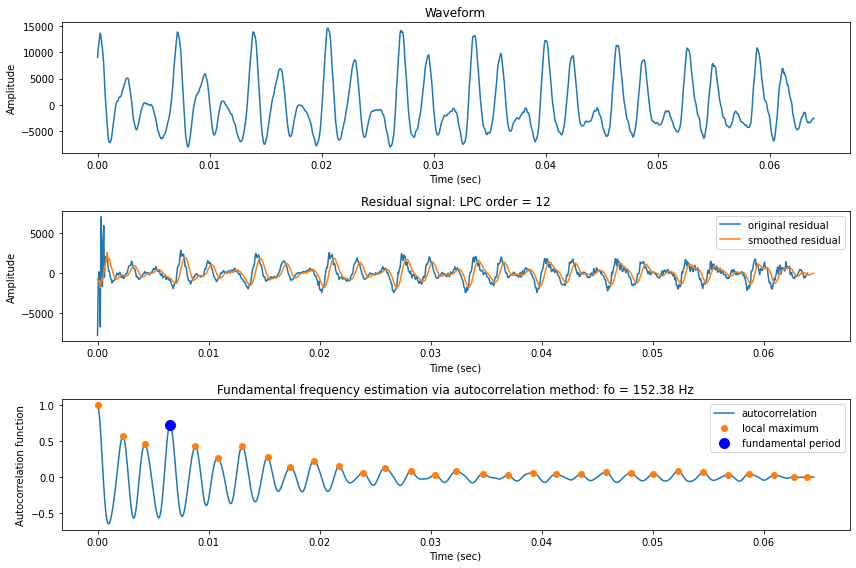

In [7]:
# パワーが最大となるフレームの音声波形を表示
fig = plt.figure(figsize=(12, 8))
time = np.arange(len(pow_max_frame)) / fs
axes = fig.add_subplot(3, 1, 1)
axes.plot(time, pow_max_frame, label="original")
axes.set_xlabel("Time (sec)")
axes.set_ylabel("Amplitude")
axes.set_title("Waveform")

# 残差信号を表示
axes = fig.add_subplot(3, 1, 2)
time = np.arange(len(residual)) / fs
axes.plot(time, residual, label="original residual")
time = np.arange(len(smoothed)) / fs
axes.plot(time, smoothed, label="smoothed residual")
axes.set_xlabel("Time (sec)")
axes.set_ylabel("Amplitude")
axes.set_title(f"Residual signal: LPC order = {LPC_ORDER}")
axes.legend()

# 自己相関関数と極大値を表示
axes = fig.add_subplot(3, 1, 3)
axes.plot(time, autocorr, label="autocorrelation")
axes.plot(time[relmax_index], autocorr[relmax_index], marker="o",
          linestyle='', label="local maximum")
axes.plot([0], autocorr[0], marker="o", linestyle='', color='#ff7f00')
axes.plot(time[relmax_index[peak_index]],
          autocorr[relmax_index[peak_index]],
          marker="o", markersize='10', linestyle='', color='blue',
          label="fundamental period")
axes.set_xlabel("Time (sec)")
axes.set_ylabel("Autocorrelation function")
axes.set_title("Fundamental frequency estimation "
               f"via autocorrelation method: fo = {fo:.2f} Hz")
plt.tight_layout()
plt.legend()

plt.show()